### Example script for reading in and plotting SAAG data
### Date created: 22 April 2025
### Author: Erin Dougherty

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# import netCDF4 as nc
# from netCDF4 import Dataset, num2date
from datetime import datetime, date, timedelta
import glob
import xarray as xr
#from cdo import *
from cdo import Cdo
import pyproj
import geopandas as gp
#import read_filecontrol
import datetime
import ulmo

### First, we will read in the SAAG CTRL data and compute the daily accumulated rainfall in the January 2000

In [2]:
saag_dir = '/glade/campaign/collections/rda/data/d616000/hist2D/200001/'

In [3]:
test = xr.open_dataset('/glade/campaign/collections/rda/data/d616000/hist2D/200001/wrf2d_d01_2000-01-01_100000.nc')

In [4]:
var = 'PREC_ACC_NC'

#### get list of files from directory to read in

In [5]:
%%time
all_files = sorted(glob.glob(saag_dir+'wrf2d*'))
pcpfile = xr.open_mfdataset(all_files)[var].resample(Time='D').sum()

CPU times: user 8min 45s, sys: 31.8 s, total: 9min 17s
Wall time: 25min 34s


In [6]:
print(pcpfile)

<xarray.DataArray 'PREC_ACC_NC' (Time: 31, south_north: 2027, west_east: 1471)>
dask.array<stack, shape=(31, 2027, 1471), dtype=float32, chunksize=(1, 2027, 1471), chunktype=numpy.ndarray>
Coordinates:
    XLAT     (south_north, west_east) float32 dask.array<chunksize=(2027, 1471), meta=np.ndarray>
    XLONG    (south_north, west_east) float32 dask.array<chunksize=(2027, 1471), meta=np.ndarray>
  * Time     (Time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-01-31
Dimensions without coordinates: south_north, west_east


### get constants data and South America shapefiles

In [7]:
saag_constants = xr.open_dataset('/glade/campaign/collections/rda/data/d616000/INVARIANT/wrfconstants_SAAG.nc')

In [8]:
lat = saag_constants.XLAT.values
lon = saag_constants.XLONG.values
elev = saag_constants.HGT.values

In [9]:
### import U.S. state shapefile
from cartopy.io import shapereader
import geopandas as gp
from geopandas import GeoDataFrame

sa = gp.GeoDataFrame.from_file("/glade/work/doughert/relampago/south_america/carcarana.shp")
sa.head()
print(len(sa))
#state = us_st['geometry'].values[0:56]

12002


### plot the total monthly precipitation over South America

In [11]:
monthly_pcp = pcpfile.sum(dim='Time')

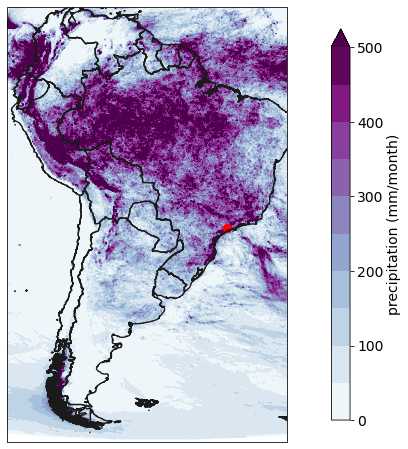

CPU times: user 1min 33s, sys: 5.3 s, total: 1min 38s
Wall time: 6min 1s


In [33]:
%%time
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.colors as colors
from matplotlib import ticker, cm
import matplotlib.patches as mpatches

fig = plt.figure(figsize = (16,8))
cmap = 'BuPu'
v = np.linspace(0,500, 11,endpoint = True)

ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.add_geometries(sa['geometry'].values, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='0.1', linewidth = 1.3, zorder=6)
ax.set_extent([-82, -37, -58, 12], crs=ccrs.PlateCarree()) 
sc = ax.contourf(lon, lat, monthly_pcp, v, cmap=cmap, extend='max',transform=ccrs.PlateCarree())
ax.scatter(-46.64,-23.55, color='r', s=70, transform=ccrs.PlateCarree())
cbar1 = plt.colorbar(sc, orientation = 'vertical', shrink=0.9)
cbar1.set_label('precipitation (mm/month)', fontsize=14,)
cbar1.ax.tick_params(labelsize=14)

#plt.savefig('snotel_CONUS404_eastriver_mean_annual_accum_precip.png', bbox_inches='tight', transparent=False, facecolor='white', dpi=250)
plt.show()

### plot daily precipitation over Sao Paulo

#### find closest point to Sao Paulo

In [34]:
sp_lon = -46.64,
sp_lat =-23.55

In [36]:
abslon = np.abs(lon- sp_lon) 
abslat = np.abs(lat -  sp_lat) 
c= np.maximum(abslon, abslat) 

In [41]:
x = np.where(c == np.min(c))[0][0]
y = np.where(c == np.min(c))[1][0]

In [43]:
sp_saag_pcp = pcpfile[:,x,y]

In [50]:
print(sp_saag_pcp)

<xarray.DataArray 'PREC_ACC_NC' (Time: 31)>
dask.array<getitem, shape=(31,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    XLAT     float32 dask.array<chunksize=(), meta=np.ndarray>
    XLONG    float32 dask.array<chunksize=(), meta=np.ndarray>
  * Time     (Time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-01-31


#### plot daily precipitation 

No handles with labels found to put in legend.


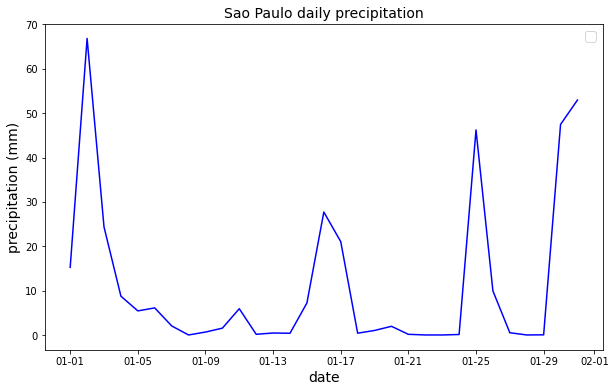

In [53]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.dates as mdates

fig = plt.subplots(figsize = (10,6))

myFmt = mdates.DateFormatter('%m-%d')

ax1 = plt.subplot(1, 1, 1)
ax1.plot(sp_saag_pcp.Time, sp_saag_pcp.values, c='b',)

ax1.xaxis.set_major_formatter(myFmt)
x = [1,2,3,4,5,6,7,8,9,10,11,12]
#my_xticks = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
#plt.xticks(x, my_xticks)
#plt.axvspan(2, 7, color='Grey', alpha=0.2, lw=0)

plt.legend(loc='best', fontsize = 14)
ax1.set_ylabel('precipitation (mm)', fontsize=14)
ax1.set_xlabel('date', fontsize=14)

ax1.set_title('Sao Paulo daily precipitation', loc='center', fontsize=14)
#plt.savefig('conus404_snotel_accum_pcp_site_mean.png', bbox_inches='tight', transparent=False, facecolor='white', dpi=250)
plt.show()